In [2]:
from scGeneFit.functions import *
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import NearestCentroid
import seaborn as sns
import json
import matplotlib.pyplot as plt
from phenotype_cover import GreedyPC
from src.utils.plots import line_plot
from sklearn.model_selection import train_test_split as tts

Parts of the code and hyperparameters were taken from https://github.com/solevillar/scGeneFit-python/blob/master/examples/scGeneFit_example.ipynb

In [2]:
data, labels, names = load_example_data("zeisel")
N, d = data.shape

In [3]:
clf=NearestCentroid()

def performance(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

<h2>Run scGeneFit</h2>

In [5]:
num_markers_list = list(range(5, 51, 5))

<h3>Method == 'centers'</h3>

In [ ]:
method = 'centers'
redundancy = 0.1

accuracy_list_centers = []

for num_markers in tqdm(num_markers_list):
    markers = get_markers_hierarchy(
        data, labels,
        num_markers,
        method=method,
        redundancy=redundancy)

    accuracy_markers = performance(
        data[:,markers], labels[0],
        data[:,markers], labels[0],
        clf)
    accuracy_list_centers.append(accuracy_markers)

<h3>method == 'pairwise'</h3>

In [ ]:
method = 'pairwise'
sampling_rate = 0.05
n_neighbors = 3
epsilon = 10
max_constraints = 500
use_centers = False

accuracy_list_pairwise = []

for num_markers in tqdm(num_markers_list):
    markers= get_markers_hierarchy(
        data, labels,
        num_markers,
        method=method,
        sampling_rate=sampling_rate,
        n_neighbors=n_neighbors,
        epsilon=epsilon)

    accuracy_markers = performance(
        data[:, markers], labels[0],
        data[:, markers], labels[0],
        clf)
    accuracy_list_pairwise.append(accuracy_markers)

<h3>method == 'pairwise centers'</h3>

In [ ]:
method = 'pairwise_centers'
sampling_rate = 0.05
n_neighbors = 0
epsilon = 10
max_constraints = 500
use_centers = True

accuracy_list_pairwise_centers = []

for num_markers in tqdm(num_markers_list):
    markers = get_markers_hierarchy(
        data, labels,
        num_markers,
        method=method, 
        sampling_rate=sampling_rate,
        n_neighbors=n_neighbors,
        epsilon=epsilon)
    
    accuracy_markers = performance(
        data[:, markers], labels[0],
        data[:, markers], labels[0],
        clf)
    accuracy_list_pairwise_centers.append(accuracy_markers)

<h2>Run G-PC</h2>

In [ ]:
accuracy_list_gpc = []

gpc = GreedyPC()
gpc.fit(data, labels[0])

num_markers_list_gpc = []

for coverage in tqdm(range(2, 15)):
    markers = gpc.select(coverage)
    accuracy_markers = performance(data[:,markers], labels[0], data[:,markers], labels[0], clf)
    accuracy_list_gpc.append(accuracy_markers)
    num_markers_list_gpc.append(len(markers))

<h2>Plot</h2>

In [3]:
# Load from json for convenience
with open('data/MC/G-PC.json', 'r') as f:
    d = json.load(f)
    num_markers_list_gpc = np.array(list(d.keys())).astype(int)
    accuracy_list_gpc = list(d.values())
with open('data/MC/scGeneFit-centers.json', 'r') as f:
    d = json.load(f)
    num_markers_list = np.array(list(d.keys())).astype(int)
    accuracy_list_centers = list(d.values())
with open('data/MC/scGeneFit-pairwise.json', 'r') as f:
    accuracy_list_pairwise = list(json.load(f).values())
with open('data/MC/scGeneFit-pairwise-centers.json', 'r') as f:
    accuracy_list_pairwise_centers = list(json.load(f).values())

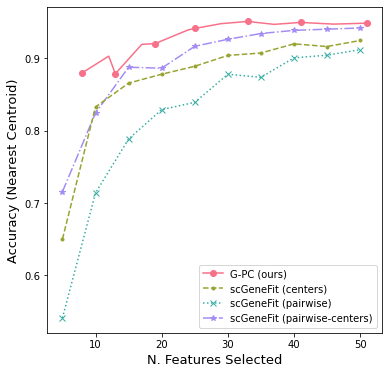

In [73]:
fig, ax = plt.subplots()

line_plot(
    xlist=[num_markers_list_gpc] + [num_markers_list] * 3,
    ylist=[accuracy_list_gpc, accuracy_list_centers, accuracy_list_pairwise, accuracy_list_pairwise_centers],
    labellist=['G-PC (ours)', 'scGeneFit (centers)', 'scGeneFit (pairwise)', 'scGeneFit (pairwise-centers)'],
    ax=ax,
    xlabel='N. Features Selected',
    ylabel='Accuracy (Nearest Centroid)',
    palette='husl',
)

fig.set_size_inches((6, 6))

plt.savefig(f'data/MC/images/scGeneFit_comparison.svg', dpi=300, transparent=True, bbox_inches='tight')